### This code illustrates how to compute the positional cylindrical distribution function for a single $CO_{2}$ molecule in a given trajectory

### Prerequisite:
* CoordinationNumbers code example
* MSD_calculation.ipynb
* OCF_calculation.ipynb

### Package Required:
* numpy
* mdtraj
* matplotlib
* xmltodict

#### Note: If you don't have the packages listed above installed, then you can type in the following commands in the terminal
* conda install numpy
* conda install -c conda-forge mdtraj
* conda install matplotlib
* conda install anaconda::xmltodict

### File Required:
* A trajectory file (.h5)

* Note: Here, I use a trajectory that contains only one CO2 molecule as an example (~/pikachu/homes/zhuo/haverford/code_example/BMIM_PF6_CO2_system_eq_step4.h5), but this code can also be used for systems with multiple CO2 molecules.

### Background:

* Cylindrical distribution function (CDF)

Cylindrical distribution function (g) is an extension of radial distribution function from a one-dimension (r) to a two-dimension projection (r and z) as shown below. 

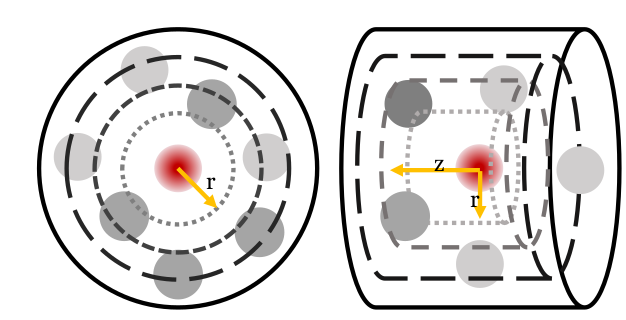

Visual depiction of (L) RDF and (R) CDF 

To calculate CDF, we first need to define a center particle and a pointing particle as the z-axis. In this case, we chose the C atom in CO2 as the center atom and the O atom in CO2 as the pointing atom to define the z-axis along the C=O bond. After that, the particle of interest is chosen as the P atom in PF6 in this p-CDF example. Therefore, the r and z terms can be calculated as below. 

$$z = \hat{v_{CO}}\cdot \vec{v_{CP}}$$

where $\hat{v_{CO}}$ is the unit vector of $\vec{v_{CO}}$ and $\vec{v_{CP}}$ is the pointing vector from C atom to the P atom. 

$$r = |\vec{v_{CP}}- z\hat{v_{CO}}|$$

After getting the r and z terms, the CDF can be calculated using the functions below to provide information on how other particle/charge surrounds a chosen particle within an area of interest. 

p-CDF: $$g(r,z) = \frac{\rho(r,z)}{\rho}$$ 

where $\rho$ is the number density of the particle of interest in bulk (or the simulation box):

$$\rho = \frac{N_{particle}}{V_{box}}$$

and $\rho(r, z)$ is the number density of the particle of interest in a chosen bin from (r, z) to (r+$\Delta r$, z) or from (r, z) to (r, z+$\Delta z$). Typically, we pick $\Delta r$ = $\Delta z$ for simplication. 

$$\rho(r, z) = \frac{N_{particle}}{V(r, z)}$$

and $V(r, z)$ is the volume of a chosen bin, which is calculated from 

$$V(r, z) = V(r+\Delta r,z) - V(r,z) = \pi(2r+\Delta r)\Delta r\Delta z$$

q-CDF: $$g(r,z) = \frac{q(r,z)}{V(r, z)}$$ 

where $q(r,z)$ is the total charge of the particle of interest in a chosen bin (r, z)

### The Actual Code:

1. Import the required package

In [5]:
import mdtraj as md
import numpy as np
import xmltodict

2. Load the trajectory file 

In [6]:
traj = md.load_hdf5('BMIM_PF6_CO2_system_eq_step4.h5')
traj

<mdtraj.Trajectory with 10000 frames, 12550 atoms, 513 residues, and unitcells at 0x7ff5f7157380>

3. Extract some basic information from the trajectory

In [7]:
box_sizes = traj.unitcell_lengths[0]*10 # in \AA
box_sizes

array([44.480778, 44.480778, 44.480778], dtype=float32)

In [8]:
n_frames = traj.n_frames
n_frames

10000

In [9]:
n_atoms = traj.n_atoms
n_atoms

12550

In [10]:
timestep = traj.timestep/1000 # convert ps into ns here
timestep

0.01

4. Select the center atom, the z-axis, and the atom of interest. Here, we are using the carbon atom in CO2 as the center atom, the C=O bond as the z-axis, and the phosphorus atom in PF6 as the atom of interest

In [11]:
POI_C = traj.topology.select("name == C")
POI_O = traj.topology.select("element == O")
POI_atoms = traj.topology.select("element == P")

In [12]:
xyz_carbon = traj.xyz[:,POI_C,:]*10 # in \AA
xyz_oxygen = traj.xyz[:,POI_O,:]*10 # in \AA
xyz_atoms = traj.xyz[:,POI_atoms,:]*10 # in \AA

5. Calculate the number density of the atom of interest within the system

In [13]:
Volume_box = box_sizes[0]**3
Volume_box

88006.97968226256

In [14]:
number_atoms = len(POI_atoms)
number_atoms

256

In [15]:
num_density_box = number_atoms/Volume_box # in the unit of atoms/\AA**3
num_density_box

0.002908860194092034

6. Define the region of interest (ROI)

In [16]:
R_Max = 5  # in \AA
R_Min = 0 # in \AA
Z_Max = 5 # in \AA
Z_Min = -5 # in \AA
r_bins = 50
z_bins = 100 
delta_R = (R_Max - R_Min)/r_bins 
delta_Z = (Z_Max - Z_Min)/z_bins


In [17]:
# Volume for each bin at different r value
pi = np.pi
Volume = np.zeros(r_bins)
r = np.arange(0,R_Max,delta_R)
r_bins

50

In [18]:
for i in np.arange(r_bins):
    Volume[i] = pi*(2*r[i]+delta_R)*delta_R*delta_Z
Volume    

array([0.00314159, 0.00942478, 0.01570796, 0.02199115, 0.02827433,
       0.03455752, 0.0408407 , 0.04712389, 0.05340708, 0.05969026,
       0.06597345, 0.07225663, 0.07853982, 0.084823  , 0.09110619,
       0.09738937, 0.10367256, 0.10995574, 0.11623893, 0.12252211,
       0.1288053 , 0.13508848, 0.14137167, 0.14765485, 0.15393804,
       0.16022123, 0.16650441, 0.1727876 , 0.17907078, 0.18535397,
       0.19163715, 0.19792034, 0.20420352, 0.21048671, 0.21676989,
       0.22305308, 0.22933626, 0.23561945, 0.24190263, 0.24818582,
       0.254469  , 0.26075219, 0.26703538, 0.27331856, 0.27960175,
       0.28588493, 0.29216812, 0.2984513 , 0.30473449, 0.31101767])

7. Define the time separation to look at the dynamic of the atom of interest

In [19]:
time_separation = 0 # in ns

if time_separation == 0:
    frame_separation = 0
elif time_separation < timestep:
    print("The smallest time separation between frames is %d, which is greater than the given input. Try again!" %(timestep)) 
    exit(1)
else:
    frame_separation = int(time_separation/timestep)

frame_separation # the number of frames within the defined time separation  

0

8. Define periodic boundary conditions

In [20]:
def vector_pbc(x0,x1,Box):
    """
    calculate vector with periodic boundary condition

    x0 -- initial position
    x1 -- finial position
    Box -- box size
    everything is in 1D, but can be used to calculate multiple dimensions as well
    """

    delta = x1 - x0
    delta= np.where(np.abs(delta) > 0.5 * Box, np.where(delta > 0, np.abs(delta)-Box,Box-np.abs(delta)), delta)
    return delta

8. Calculate the p-CDF

In [21]:
rho = np.zeros([r_bins,z_bins]) # Define an empty array rho
i = frame_separation

vector_CO1 = vector_pbc(xyz_carbon[np.arange(0,n_frames-i),:,:],xyz_oxygen[np.arange(0,n_frames-i),:,:],box_sizes) # Compute the C=O vector at time t1
vector_CO2 = vector_pbc(xyz_carbon[np.arange(i,n_frames),:,:],xyz_oxygen[np.arange(i,n_frames),:,:],box_sizes)  # Compute the C=O vector at time t2   
vector_CO1_norm = vector_CO1/np.expand_dims(np.linalg.norm(vector_CO1, axis=-1), 2) # Normalize the vector as a unit vector
vector_CO2_norm = vector_CO2/np.expand_dims(np.linalg.norm(vector_CO2, axis=-1), 2)
vector_CI1 = vector_pbc(xyz_carbon[np.arange(0,n_frames-i),:,:],xyz_atoms[np.arange(0,n_frames-i),:,:],box_sizes) # Compute the CI vector at time t1
vector_CI2 = vector_pbc(xyz_carbon[np.arange(i,n_frames),:,:],xyz_atoms[np.arange(i,n_frames),:,:],box_sizes)  # Compute the CI vector at time t2   

for j in np.arange(vector_CO1.shape[0]):
    for k in range(0,len(POI_O)): 
        z_1 = np.dot(vector_CI1[j],vector_CO1_norm[j][k].T) # Calculate the height 
        z_2 = np.dot(vector_CI2[j],vector_CO2_norm[j][k].T)
        r_1 = np.linalg.norm(vector_CI1[j] - np.expand_dims(z_1,1)*vector_CO1_norm[j][k].T, axis=-1) # calculate the r vector
        r_2 = np.linalg.norm(vector_CI2[j] - np.expand_dims(z_2,1)*vector_CO2_norm[j][k].T, axis=-1)
        for l in range(0,len(z_1)):
            if r_1[l] < R_Max and Z_Min < z_1[l] < Z_Max: # Check if the vectors remain in the ROI throughout the time separation
                if r_2[l] < R_Max and Z_Min < z_2[l] < Z_Max:
                    rho[int(r_1[l]/delta_R), int(z_1[l]/delta_Z+50)] += 1/Volume[int(r_1[l]/delta_R)] # counting the number of particles within the region and then divide by the associate volume and then divide by the number density of the system
                else:
                    continue
CDF = rho/num_density_box/(n_frames-frame_separation)/len(POI_O)   
CDF

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.03668349, 0.92149644, 0.69112233, ..., 1.03668349, 0.97908996,
        0.69112233],
       [0.78968445, 0.90249651, 1.18452667, ..., 0.62046635, 0.73327841,
        0.62046635],
       [0.60793168, 0.93953077, 1.05006381, ..., 0.82899774, 0.93953077,
        0.77373123]])

9. Save the data into .txt file

In [22]:
np.savetxt('BMIM_PF6_CO2_system_eq_step4_CDF_P_0_ns.txt', CDF,fmt ='%.6f',delimiter = ',', header = 'R, Z')

10. Plotting

In [23]:
import matplotlib.pyplot as plt

Define the plotting range

In [24]:
R, Z = np.mgrid[slice(-R_Max, R_Max+delta_R, delta_R),
                 slice(Z_Min, Z_Max+delta_R, delta_Z)]
R, Z

(array([[-5. , -5. , -5. , ..., -5. , -5. , -5. ],
        [-4.9, -4.9, -4.9, ..., -4.9, -4.9, -4.9],
        [-4.8, -4.8, -4.8, ..., -4.8, -4.8, -4.8],
        ...,
        [ 4.8,  4.8,  4.8, ...,  4.8,  4.8,  4.8],
        [ 4.9,  4.9,  4.9, ...,  4.9,  4.9,  4.9],
        [ 5. ,  5. ,  5. , ...,  5. ,  5. ,  5. ]]),
 array([[-5. , -4.9, -4.8, ...,  4.8,  4.9,  5. ],
        [-5. , -4.9, -4.8, ...,  4.8,  4.9,  5. ],
        [-5. , -4.9, -4.8, ...,  4.8,  4.9,  5. ],
        ...,
        [-5. , -4.9, -4.8, ...,  4.8,  4.9,  5. ],
        [-5. , -4.9, -4.8, ...,  4.8,  4.9,  5. ],
        [-5. , -4.9, -4.8, ...,  4.8,  4.9,  5. ]]))

In [25]:
intensity = np.concatenate((np.flipud(CDF),CDF)).T  # vertically flip the data and combine with the old data to mirror the dataset
intensity

array([[0.60793168, 0.78968445, 1.03668349, ..., 1.03668349, 0.78968445,
        0.60793168],
       [0.93953077, 0.90249651, 0.92149644, ..., 0.92149644, 0.90249651,
        0.93953077],
       [1.05006381, 1.18452667, 0.69112233, ..., 0.69112233, 1.18452667,
        1.05006381],
       ...,
       [0.82899774, 0.62046635, 1.03668349, ..., 1.03668349, 0.62046635,
        0.82899774],
       [0.93953077, 0.73327841, 0.97908996, ..., 0.97908996, 0.73327841,
        0.93953077],
       [0.77373123, 0.62046635, 0.69112233, ..., 0.69112233, 0.62046635,
        0.77373123]])

Plot heatmap

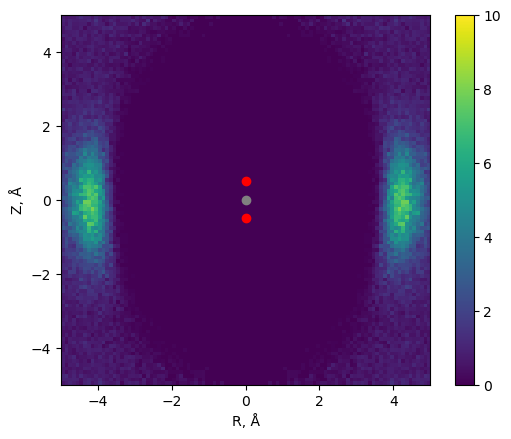

In [26]:
plt.imshow(intensity,origin='lower', vmin=0, vmax=10,extent=[R.min(), R.max(), Z.min(), Z.max()])
plt.colorbar()
plt.xlabel(r'R, Å')
plt.ylabel(r'Z, Å')
plt.scatter(0, 0, color='grey')
plt.scatter(0,0.5,color='red')
plt.scatter(0,-0.5,color='red')

Plot contour plot

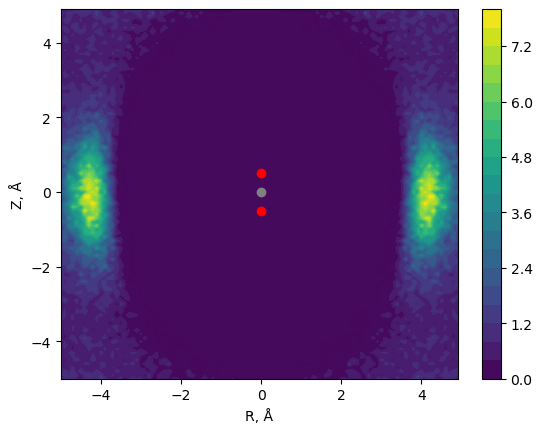

In [27]:
plt.contourf(np.arange(-R_Max,R_Max,delta_R), np.arange(Z_Min,Z_Max,delta_Z), intensity, levels=20, cmap='viridis')
colorbar = plt.colorbar()
plt.contour(np.arange(-R_Max,R_Max,delta_R), np.arange(Z_Min,Z_Max,delta_Z), intensity, levels=20,alpha=0.2)  # levels determine the number of contour lines
plt.xlabel(r'R, Å')
plt.ylabel(r'Z, Å')
plt.scatter(0, 0, color='grey')
plt.scatter(0,0.5,color='red')
plt.scatter(0,-0.5,color='red')